In this tutorial, we recall the *port-Hamiltonian systems (PHS)* formalism in parallel with a description of the `pyphs.Core` object. As an example, we derive a PHS formulation of the Thiele-Small model of the loudspeaker as the connection of a two-ports serial resistor-inductor (RL) circuit with a mass-spring-damper (MKA) system.
<!-- TEASER_END -->

The corresponding Python script `core.py` can be found in the tutorials at `\pyphs\tutorials\`

Steps are:
1. Governing equations for the RL circuit
2. pyphs.Core instantiation
3. Adding the components
4. Defining the interconnection structure
5. The mass-spring-damper (MKA)
6. Connection of two pyphs.Core
7. Setting the physical parameters values
8. Reduce the linear dissipative relations
9. Avoid inverse evaluations of the parameters
10. Generate a $\LaTeX$ description

# 1. Governing equations for the RL circuit
The two-ports RL circuit is described as follows:
* $x_L$ is the coil flux so that $v_L = \frac{\mathrm d x_L}{\mathrm d  t}$ is the coil voltage,  
* $w_R= i_R$ is the resistor current, 
* $y1=i_{\mathrm{1}}$ is the current at port #1 
* $u1=v_1$ is the voltage at port #1.
* $y2=i_{\mathrm{2}}$ is the current at port #2 
* $u2=v_2$ is the voltage at port #2.

For this tutorial, the constitutive laws are:
* the storage function (Hamiltonian) $$H(x_L)=\frac{x_L^2}{2L}$$ so that the (linear) coil current is $i_L=\frac{\partial H}{\partial x_L}=\frac{x_L}{L}$,
* the linear dissipation function $z_R(w_R)= R \,w_R = v_R$ with $v_R$ the resistor voltage. 

The Kirchhoff's laws for a serial connection read: 
* Kirchhoff's current law: $ v_L=-v_C-v_R-v_1-v2$,
* Kirchhoff's vcurrent law: $i_L = i_R = i_1 = i_2$.

This can be expressed in the *Port-Hamiltonian Systems* (PHS) formalism as:

\begin{equation}
\begin{pmatrix}
\frac{dx_L}{dt} \\
\hline
w_R \\
\hline
y_1 \\
y_2
\end{pmatrix}
= 
\left(
\begin{array}{c|c|cc|c}
0 &-1 &-1& -1 \\
\hline
+1 &0 &0 &0 \\
\hline
+1 &0 &0& 0 \\
+1 &0& 0 &0
\end{array}
\right)
\begin{pmatrix}
\frac{dH}{dx_L} \\
\hline
z(w_R) \\
\hline
u_1 \\
u_2
\end{pmatrix}
\end{equation}

#### Physical parameters
* $L=500\times 10^{-3}$H, 
* $R = 10^2\Omega$.

# 2. pyphs.Core instantiation

In this tutorial, we need only the core PHS structure implemented by the `pyphs.Core` object:

In [1]:
# import of the pyphs.Core class
from pyphs import Core

The instantiation takes an optional argument `label`:

In [2]:
# instantiate a pyphs.PHSCore object
RL = Core(label='my_core')

Now, `RL` is a new instance of the `pyphs.Core` class, that is, an empty Port-Hamiltonian System:

In [3]:
isinstance(RL, Core)

True

In [4]:
RL.x

[]

In [5]:
RL.H

0

In [6]:
RL.dims.w()

0

In [7]:
RL.M

Matrix(0, 0, [])

# 3. Adding the components
The pyphs package is based on the `sympy` package to provides the symbolic manipulation of PHS structures. 

## 3.1 Defining symbols

To declare symbols, we use the `Core.symbols` method which is a shortcut for `sympy.symbols`method. Below, we declare the symbols associated with the coil:

* the state $x_L$ (magnetic flux of the coil measured in Weber), and
* the parameter $L$ (coil inductance measured in Henry).

In [8]:
xL, L = RL.symbols(['xL', 'L'])
xL

xL

> Notice all symbols in `PyPHS` are assumed **real-valued only**. This is to alleviate complex solutions during the manipulation of expressions.

## 3.2 Define expressions
Now, the variables `xL` and `L` are instances of the `Core.symbols` object, and expressions are defined with the standard `sympy` syntax. Below, we define the storage function associated with the coil $H_L(x_L)=\frac{x_L^2}{2L}$:

In [9]:
HL = xL**2/(2*L)

## 3.3 Adding storages
To include a storage component to a `Core`, we make use of the `add_storages` method. As an example, the coil is added to the `Core` object as follows:

In [10]:
RL.add_storages(xL, HL)
RL.x

[xL]

In [11]:
RL.H

xL**2/(2*L)

## 3.4 Adding dissipations 
To include a dissipative component to a `Core`, we make use of the `add_dissipations` method. Recall the resistor is decribed by:
* the dissipative variable $w_R$ (resistor current),
* the parameter $R$ (electric resistance), and 
* the dissipation function $z_R(w_R)=R\,w_R$.

This component is added to the `Core` object as follows: 

In [12]:
wR, R = RL.symbols(['wR', 'R'])    # define sympy symbols
zR = R*wR                           # define sympy expression
RL.add_dissipations(wR, zR)        # add dissipation to the `core` object

Now, the dissipative variable of the `core` object includes `wR` only:

In [13]:
RL.w

[wR]

and the dissipation function is given by `zR` only:

In [14]:
RL.z

[R*wR]

## 3.5 Adding ports
To include an external port to a `PHSCore` object, we make use of the `core.add_ports` method. Below, we define the external port with input $u=v_{\mathrm{out}}$ and output $y=i_{\mathrm{out}}$ (notice the symbols do not reflect the actual physical meaning of $u$ and $y$):

In [15]:
u1, y1, u2, y2 = RL.symbols(['v1', 'i1', 'v2', 'i2']) # define sympy symbols
RL.add_ports([u1, u2], [y1, y2])                  # add the port to the `core` object

In [16]:
RL.u

[v1, v2]

In [17]:
RL.y

[i1, i2]

# 4. Defining the interconnection structure
The interconnection structure of a PHS is defined by the matrix $\mathbf M$ structured as $$\mathbf M = \mathbf J- \mathbf R,$$ where 
* the skew-symmetric matrix $\mathbf J = \frac{1}{2}\left(\mathbf M- \mathbf M^\intercal\right) $ encodes the *conservative interconnection*, and 
* the symmetric positive definite matrix $\mathbf R = \frac{-1}{2}\left(\mathbf M + \mathbf M^\intercal\right)$ encodes the *dissipative interconnection*.

These matrices are decomposed in blocks as follows:
$$\mathbf M = \left( 
\begin{array}{lll}
\mathbf M_{\mathrm{xx}} & \mathbf M_{\mathrm{xw}} & \mathbf M_{\mathrm{xy}} \\
\mathbf M_{\mathrm{wx}} & \mathbf M_{\mathrm{ww}} & \mathbf M_{\mathrm{wy}} \\
\mathbf M_{\mathrm{yx}} & \mathbf M_{\mathrm{ww}} & \mathbf M_{\mathrm{yy}} \\
\end{array}\right), 
$$
$$
\mathbf J = \left( 
\begin{array}{lll}
\mathbf J_{\mathrm{xx}} & \mathbf J_{\mathrm{xw}} & \mathbf J_{\mathrm{xy}} \\
\mathbf J_{\mathrm{wx}} & \mathbf J_{\mathrm{ww}} & \mathbf J_{\mathrm{wy}} \\
\mathbf J_{\mathrm{yx}} & \mathbf J_{\mathrm{ww}} & \mathbf J_{\mathrm{yy}} \\
\end{array}\right), \quad\mathbf R = \left( 
\begin{array}{lll}
\mathbf R_{\mathrm{xx}} & \mathbf R_{\mathrm{xw}} & \mathbf R_{\mathrm{xy}} \\
\mathbf R_{\mathrm{wx}} & \mathbf R_{\mathrm{ww}} & \mathbf R_{\mathrm{wy}} \\
\mathbf R_{\mathrm{yx}} & \mathbf R_{\mathrm{ww}} & \mathbf R_{\mathrm{yy}} \\
\end{array}\right).$$

For the above description of the RLC circuit, the matrices are $$\mathbf M = \mathbf J = \left(\begin{array}{cc|c|c}
0 & -1 & -1 & -1\\ 
+1 & 0 & 0 & 0 \\ \hline
+1 & 0 & 0 & 0 \\  \hline
+1 & 0 & 0 & 0
\end{array}\right),$$ 
that is, $\mathbf R=0$. 

> Notice `core.M` only is an attribute, all other matrices are accessed with *getters* (e.g. `core.J()`, `core.Jxx()`, `core.Rxy()`, `core.Mwy()`) and *setters* (e.g. `core.set_J()`, `core.set_Jxx()`, `core.set_Rxy()`, `core.set_Mwy()`).

First, we initialize the matrix $\mathbf M$ with zeros:

In [18]:
RL.init_M()

RL.M

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [19]:
RL.set_Mxx([0])
RL.M

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [20]:
Jxw = [[-1]]
RL.set_Jxw(Jxw)

RL.M

Matrix([
[0, -1, 0, 0],
[1,  0, 0, 0],
[0,  0, 0, 0],
[0,  0, 0, 0]])

> Notice the skew-symmetry (respectively symmetry) of $\mathbf J$ (respectively $\mathbf R$) is preserved with the *setters* `core.set_Jab` (respectively `core.set_Rab`), for $\mathtt{a, b}$ in $(\mathrm{x, w, y})^2$. Above, $\mathbf{J}_{\mathrm{wx}}=-\mathbf{J}_{\mathrm{xw}}^{\intercal}$ has been automatically updated.

In [21]:
RL.set_Jxy([[-1, -1]])
RL.M

Matrix([
[0, -1, -1, -1],
[1,  0,  0,  0],
[1,  0,  0,  0],
[1,  0,  0,  0]])

Then, the structure matrices are accessed as follows.

In [22]:
RL.M

Matrix([
[0, -1, -1, -1],
[1,  0,  0,  0],
[1,  0,  0,  0],
[1,  0,  0,  0]])

In [23]:
RL.J()

Matrix([
[  0, -1.0, -1.0, -1.0],
[1.0,    0,    0,    0],
[1.0,    0,    0,    0],
[1.0,    0,    0,    0]])

In [24]:
RL.R()

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

# 5 The mass-spring-damper (MKA)

Below, we build the PHS associated with the one-port mass-spring-damper (MKA) system, following the same steps as described above.

* $x_K$ is the spring position so that $v_K = \frac{\mathrm d x_K}{\mathrm d  t}$ is the spring velocity,  
* $x_M$ is the mass momentum so that $f_M = \frac{\mathrm d x_M}{\mathrm d  t}$ is the force applied on the mass,  
* $w_A= v_A$ is the damper velocity, 
* $y_3=v_3$ is the velocity of port #3 
* $u_3=f_3$ is the force applied on the port #3.

For this tutorial, the constitutive laws are:
* the storage function (Hamiltonian) $$H(x_M)=\frac{x_M^2}{2M}$$ so that the (linear) velocity of the mass is $v_M=\frac{\partial H}{\partial x_M}=\frac{x_M}{M}$ and $$H(x_K)=\frac{Kx_K^2}{2}$$ so that the (linear) force applied on the spring is $f_K = Kx_K$. 
* the linear dissipation function $z_A(w_A)= A \,w_A = f_A$ with $f_A$ force applied on the damper. 


The PHS associated with the one-port mass-spring-damper (MKA) system is:

\begin{equation}
\begin{pmatrix}
\frac{dx_K}{dt} \\
\frac{dx_M}{dt} \\
\hline
w_A \\
\hline
v_3 
\end{pmatrix}
= 
\left(
\begin{array}{c c|c|c}
0 &1 &0& 0 \\
-1 &0 &-1 &-1 \\
\hline
0 &1 &0& 0 \\
\hline
0 &1& 0 &0
\end{array}
\right)
\begin{pmatrix}
\frac{dH}{dx_K} \\
\frac{dH}{dx_M} \\
\hline
z(w_A) \\
\hline
f_3
\end{pmatrix}
\end{equation}

The MKA `Core` object as above:

In [25]:
# 1. Instantiate the MKA Core
MKA = Core()

# 2Define all symbols
xK, K, xM, M, wA, A, u3, v3 = MKA.symbols(['xK', 'K', 'xM', 'M', 'wA', 'A', 'f3', 'V3'])

# Define the constitutive laws
HK = (xK**2)*(K/2)
HM = (xM**2)/(2*M)
zA = wA*A 

# Add all the components
MKA.add_storages([xK, xM], HK + HM)
MKA.add_dissipations(wA, zA)
MKA.add_ports(u3, v3)

# Initialize the interconnexion matrix
MKA.init_M()

# It is possible to define M at once with a sympy.SparseMatrix
import sympy
MKA.M = sympy.SparseMatrix([[0, 1, 0, 0], [-1, 0, -1, -1], [0, 1, 0, 0], [0, 1, 0, 0]])

MKA.pprint()

⎡                         ⎡K⋅xK⎤⎤
⎢⎡dtxK⎤  ⎡0   1  0   0 ⎤  ⎢    ⎥⎥
⎢⎢    ⎥  ⎢             ⎥  ⎢ xM ⎥⎥
⎢⎢dtxM⎥  ⎢-1  0  -1  -1⎥  ⎢ ── ⎥⎥
⎢⎢    ⎥, ⎢             ⎥, ⎢ M  ⎥⎥
⎢⎢ wA ⎥  ⎢0   1  0   0 ⎥  ⎢    ⎥⎥
⎢⎢    ⎥  ⎢             ⎥  ⎢A⋅wA⎥⎥
⎢⎣ V₃ ⎦  ⎣0   1  0   0 ⎦  ⎢    ⎥⎥
⎣                         ⎣ f₃ ⎦⎦


# 6. Connection of two pyphs.Core

This section describes how to connect two `pyphs.Core` instances. As an example, the Thiele-Small model of a loudspeaker is built as the connexion between of a the previous RL circuit with a mass-spring-damper (MKA) system through a gyrator $BL$.  

The connection is realized in three steps:
1. Assembly: Two `pyphs.Core` instances are concatenated in a single object.
2. Dual feedback: $N$ outputs of the resulting `pyphs.Core` are feed back into $N$ of its own inputs.
3. Connection: The associated relations are embeded in the `pyphs.Core` structure.

## 6.1 Assembly
The `+` operator is used to assemble two `pyphs.Core` instances in a single object. Below, we assemble the *RL* circuit and the *MKA* system in a `pyphs.Core` named *SPK*.

In [26]:
SPK = RL + MKA

Vectors quantities from `RL` and `MKA` are concatenated into `SPK`:

In [27]:
SPK.pprint()

⎡                                        ⎡ xL ⎤⎤
⎢                                        ⎢ ── ⎥⎥
⎢⎡dtxL⎤  ⎡0  0   0  -1  0   -1  -1  0 ⎤  ⎢ L  ⎥⎥
⎢⎢    ⎥  ⎢                            ⎥  ⎢    ⎥⎥
⎢⎢dtxK⎥  ⎢0  0   1  0   0   0   0   0 ⎥  ⎢K⋅xK⎥⎥
⎢⎢    ⎥  ⎢                            ⎥  ⎢    ⎥⎥
⎢⎢dtxM⎥  ⎢0  -1  0  0   -1  0   0   -1⎥  ⎢ xM ⎥⎥
⎢⎢    ⎥  ⎢                            ⎥  ⎢ ── ⎥⎥
⎢⎢ wR ⎥  ⎢1  0   0  0   0   0   0   0 ⎥  ⎢ M  ⎥⎥
⎢⎢    ⎥, ⎢                            ⎥, ⎢    ⎥⎥
⎢⎢ wA ⎥  ⎢0  0   1  0   0   0   0   0 ⎥  ⎢R⋅wR⎥⎥
⎢⎢    ⎥  ⎢                            ⎥  ⎢    ⎥⎥
⎢⎢ i₁ ⎥  ⎢1  0   0  0   0   0   0   0 ⎥  ⎢A⋅wA⎥⎥
⎢⎢    ⎥  ⎢                            ⎥  ⎢    ⎥⎥
⎢⎢ i₂ ⎥  ⎢1  0   0  0   0   0   0   0 ⎥  ⎢ v₁ ⎥⎥
⎢⎢    ⎥  ⎢                            ⎥  ⎢    ⎥⎥
⎢⎣ V₃ ⎦  ⎣0  0   1  0   0   0   0   0 ⎦  ⎢ v₂ ⎥⎥
⎢                                        ⎢    ⎥⎥
⎣                                        ⎣ f₃ ⎦⎦


and the energies are added together:

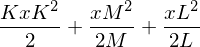

In [28]:
SPK.H

## 6.2. Dual feedback

Now we add the information of connexion of RL with MKA with the `add_connector` method. It takes 2 arguments:

1. An ordered list of ports indices $(p_1,\,p_2)$ associated with the ports to be connected 
2. A coupling coefficient $\alpha$.

The connection reads:
$$\left\{ \begin{array}{rcr}
u_{p_1} &=& +\,\alpha \, y_{p_2}, \\
u_{p_2} &=& -\,\alpha \, y_{p_1}.
\end{array}
\right.$$

The electro-mechanical coupling $BL$ of RL with MKA yields: $f_3 = +\, BL\, i_2$, that is, we connect the second output of RL into the input of MKA:

In [29]:
# define ports indeices:
p1 = SPK.u.index(MKA.u[0]) # recover the index for f3 in SPK.u
p2 = SPK.y.index(RL.y[1])  # recover the index for i2 in SPK.y

# Define the symbol BL
BL = SPK.symbols('BL')

# Add the connector SPK.u[p1] = alpha*SPK.y[p2]
SPK.add_connector((p1, p2), alpha=BL)
SPK.connectors

[{'alpha': BL, 'u': [f3, v2], 'y': [V3, i2]}]

## 6.3. Connection

Finally, the resulting relations are embeded in the PHS structure with the method `connect`:

In [30]:
# Apply the connector
SPK.connect()

The new interconnection structure reads

In [31]:
SPK.pprint()

⎡                                   ⎡ xL ⎤⎤
⎢                                   ⎢ ── ⎥⎥
⎢⎡dtxL⎤  ⎡0   0   -BL  -1  0   -1⎤  ⎢ L  ⎥⎥
⎢⎢    ⎥  ⎢                       ⎥  ⎢    ⎥⎥
⎢⎢dtxK⎥  ⎢0   0    1   0   0   0 ⎥  ⎢K⋅xK⎥⎥
⎢⎢    ⎥  ⎢                       ⎥  ⎢    ⎥⎥
⎢⎢dtxM⎥  ⎢BL  -1   0   0   -1  0 ⎥  ⎢ xM ⎥⎥
⎢⎢    ⎥, ⎢                       ⎥, ⎢ ── ⎥⎥
⎢⎢ wR ⎥  ⎢1   0    0   0   0   0 ⎥  ⎢ M  ⎥⎥
⎢⎢    ⎥  ⎢                       ⎥  ⎢    ⎥⎥
⎢⎢ wA ⎥  ⎢0   0    1   0   0   0 ⎥  ⎢R⋅wR⎥⎥
⎢⎢    ⎥  ⎢                       ⎥  ⎢    ⎥⎥
⎢⎣ i₁ ⎦  ⎣1   0    0   0   0   0 ⎦  ⎢A⋅wA⎥⎥
⎢                                   ⎢    ⎥⎥
⎣                                   ⎣ v₁ ⎦⎦



# 7. Setting the physical parameters values
The correspondace between the parameters symbols defined above (`L`, `R`, `K`, `M`, `A`, `BL`) and their actual value is stored in the python dictionary `Core.subs`, with parameters symbols as the dictionary's keys and numerical values as the dictionary's values. As an example, we choose the following physical parameters:
* $L=11\times 10^{-3}$H, 
* $R=5.7$ $\Omega$, 
* $K=4e7$ N/m, 
* $M = 19$g,
* $A = 0.406$ Ns/m,
* $BL = 2.99$ N/A.

This is stored in the `pyphs.Core` as follows:

In [32]:
# Physical parameters 
L_value = 11e-3   # H
R_value = 5.7     # Ohm
K_value = 4e7     # N/m                         
M_value = 0.019   # g
A_value = 0.406   # N.s/m
BL_value = 2.99   # N/A

subs = {L: L_value,
        R: R_value,
        K: K_value, 
        M: M_value,
        A: A_value,
        BL:BL_value
       }

SPK.subs.update(subs)

It is possible to replace the constant parameters $BL$ by a function that depends on $x_K$:
$\mathrm{BLnl}(x_k) \triangleq \mathrm{B}\,e^{-x_k^2}$

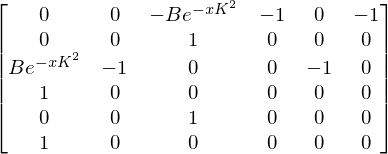

In [33]:
# Define the new expression
B = SPK.symbols('B')
BLnl = B*sympy.exp(-(SPK.x[1])**2)

#Associate the expression to BL
SPK.substitute(subs={BL: BLnl})

# Print the changes in M
SPK.M

> Notice the option `selfsubs=True` can be passed to `SPK.apply_subs` to apply the substitution of all parameters in dictionary `core.subs`.

# 8. Reduce the linear dissipative relations
The resistive interconnection due to the linear physical laws in z can be incorporated in the matrix $\mathbf R$, so that the dimension of $z$ is reduced to that of its nonlinear part.

In [34]:
SPK.reduce_z()

> Notice the methods `split_linear()` and `reduce_z()` change the organization of the vectors $\mathbf x$ and $\mathbf w$ (compare the evaluation below with the original definition).

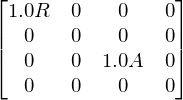

In [35]:
SPK.R()

In [36]:
SPK.pprint()

⎡        ⎡                    2    ⎤  ⎡ xL ⎤⎤
⎢        ⎢                 -xK     ⎥  ⎢ ── ⎥⎥
⎢⎡dtxL⎤  ⎢  -R     0   -B⋅ℯ      -1⎥  ⎢ L  ⎥⎥
⎢⎢    ⎥  ⎢                         ⎥  ⎢    ⎥⎥
⎢⎢dtxK⎥  ⎢   0     0      1      0 ⎥  ⎢K⋅xK⎥⎥
⎢⎢    ⎥, ⎢                         ⎥, ⎢    ⎥⎥
⎢⎢dtxM⎥  ⎢      2                  ⎥  ⎢ xM ⎥⎥
⎢⎢    ⎥  ⎢   -xK                   ⎥  ⎢ ── ⎥⎥
⎢⎣ i₁ ⎦  ⎢B⋅ℯ      -1     -A     0 ⎥  ⎢ M  ⎥⎥
⎢        ⎢                         ⎥  ⎢    ⎥⎥
⎣        ⎣   1     0      0      0 ⎦  ⎣ v₁ ⎦⎦


In [37]:
SPK.z

# 9. Avoid inverse evaluations of the parameters
To avoid the inverse relations that occurs in the system's expressions (e.g. in $H$), the method `subsinverse` can be used. It replaces inversed symbols by the same symbols with prefix 'inv', which are appended to the dictionary 'Core.subs.

In [38]:
SPK.subsinverse()

Remove Inverse of Parameters...


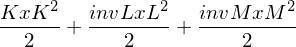

In [39]:
SPK.H

In [40]:
SPK.subs

# 10. Generate a $\LaTeX$ description
A `.tex` file containing a description of the system can now be generated with the `core.texwrite` command as follows (each argument is optional):

In [41]:
path = "SPK.tex"
title = 'Thiele-Small based nonlinear model of loudspeakers'

SPK.texwrite(path=path, 
             title=title)

A [SPK.tex](/pyphs_outputs/SPK.tex) has been generated, the compilation of which yields the following [SPK.pdf](/pyphs_outputs/SPK.pdf).